In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyts
# from pyts.classification import LearningShapelets
from pyts.classification import LearningShapelets

from scipy.stats import entropy
from time import time
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sktime.datasets import load_arrow_head
from pyts.datasets import load_gunpoint

import warnings
warnings.filterwarnings('ignore')


### Assignment 1

#### a) Write a function for finding characteristic time series shapelets for a given dataset of time series.

#### b) Construct a few simple example datasets and verify the results of your function with some illustrations of the shapelets discovered and their location in some selected time series from the dataset.

#### c) Evaluate computation time of your function. Try to optimize it with your own improvements or the improvements proposed in [1].

## Assignment 2

Recall the shapelet learning algorithm described in our lecture or in [2]. Use the algorithm to discover characteristic shapelets in water consumption data from the List of Assignment 2 as well as the Gun Point Dataset and the Arrow Head Dataset. You may use either your own implementation or the implementation available in the pyts [3] package. Try to illustrate the results - present the shapelets discovered and their location in some selected time series from the dataset.

In [64]:
def plot_shapelets(clf):
    n = clf.shapelets_.shape[1]
    f, axs = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(9):
        axs[i // 3, i % 3].axis('off')
        idx = np.random.randint(0, n)
        shapelet = clf.shapelets_[0][idx]
        axs[i // 3, i % 3].plot(shapelet)
        axs[i // 3, i % 3].set_title(f'Weight: {np.round(clf.coef_[0][idx],3)}')

In [65]:
def subsequence_distance(time_series, shapelet, return_offset=False):
    time_series_length = len(time_series)
    shapelet_length = len(shapelet)

    time_series = np.array(time_series)
    shapelet = np.array(shapelet)

    min_distance = np.inf
    best_offset = -1
    for offset in range(time_series_length - shapelet_length + 1):
        dist = np.sum(
            (time_series[offset:offset + shapelet_length] - shapelet)**2)
        if dist < min_distance:
            min_distance = dist
            best_offset = offset

    if return_offset:
        return min_distance, best_offset
    return min_distance

In [66]:
def visualize_shapelets(clf, X_train, y_train):
    n = len(X_train)
    f, axs = plt.subplots(3, 3, figsize=(15, 15))

    shapelet = clf.shapelets_[0][np.random.randint(0, clf.shapelets_.shape[1])]
    for i in range(9):
        axs[i // 3, i % 3].axis('off')
        idx = np.random.randint(0, n)
        time_serie = X_train[idx]
        axs[i // 3, i % 3].plot(time_serie)

        dist, offset = subsequence_distance(time_serie,
                                            shapelet,
                                            return_offset=True)
        axs[i // 3, i % 3].plot([offset + i for i in range(len(shapelet))],
                                shapelet,
                                color='red')

        axs[i // 3, i % 3].set_title(f'Label: {y_train[idx]}')

#### water consumption dataset

In [67]:
df = pd.read_csv('water_consumption_profiles.csv')
df['date'] = df['date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df = df.set_index('date')
df_ = df.groupby([df.index.month, df.index.weekday]).mean()
X = df_.values
y = df_.reset_index([1])['date'].map(lambda x: 0 if x < 5 else 1).values
N = len(y)
shuffled_indices_ = np.random.permutation(N)
test_indices = shuffled_indices_[int(0.65 * N):].copy()
train_indices = shuffled_indices_[:int(0.65 * N)].copy()

X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]

In [68]:
clf = LearningShapelets(n_shapelets_per_size=0.2)
clf.fit(X_train, y_train)

LearningShapelets()

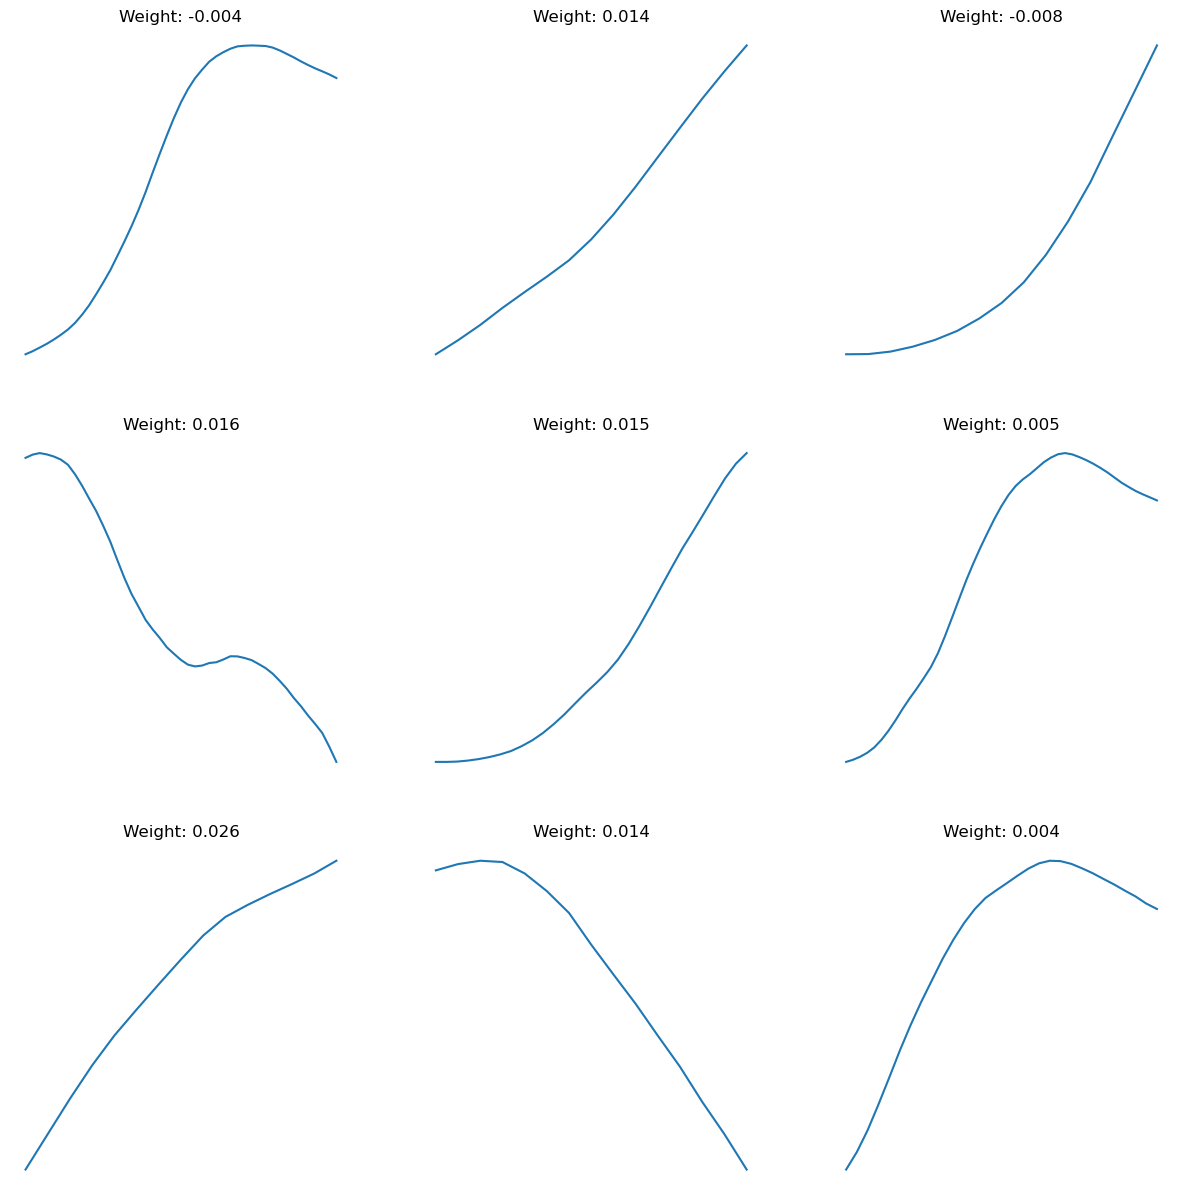

In [69]:
plot_shapelets(clf)

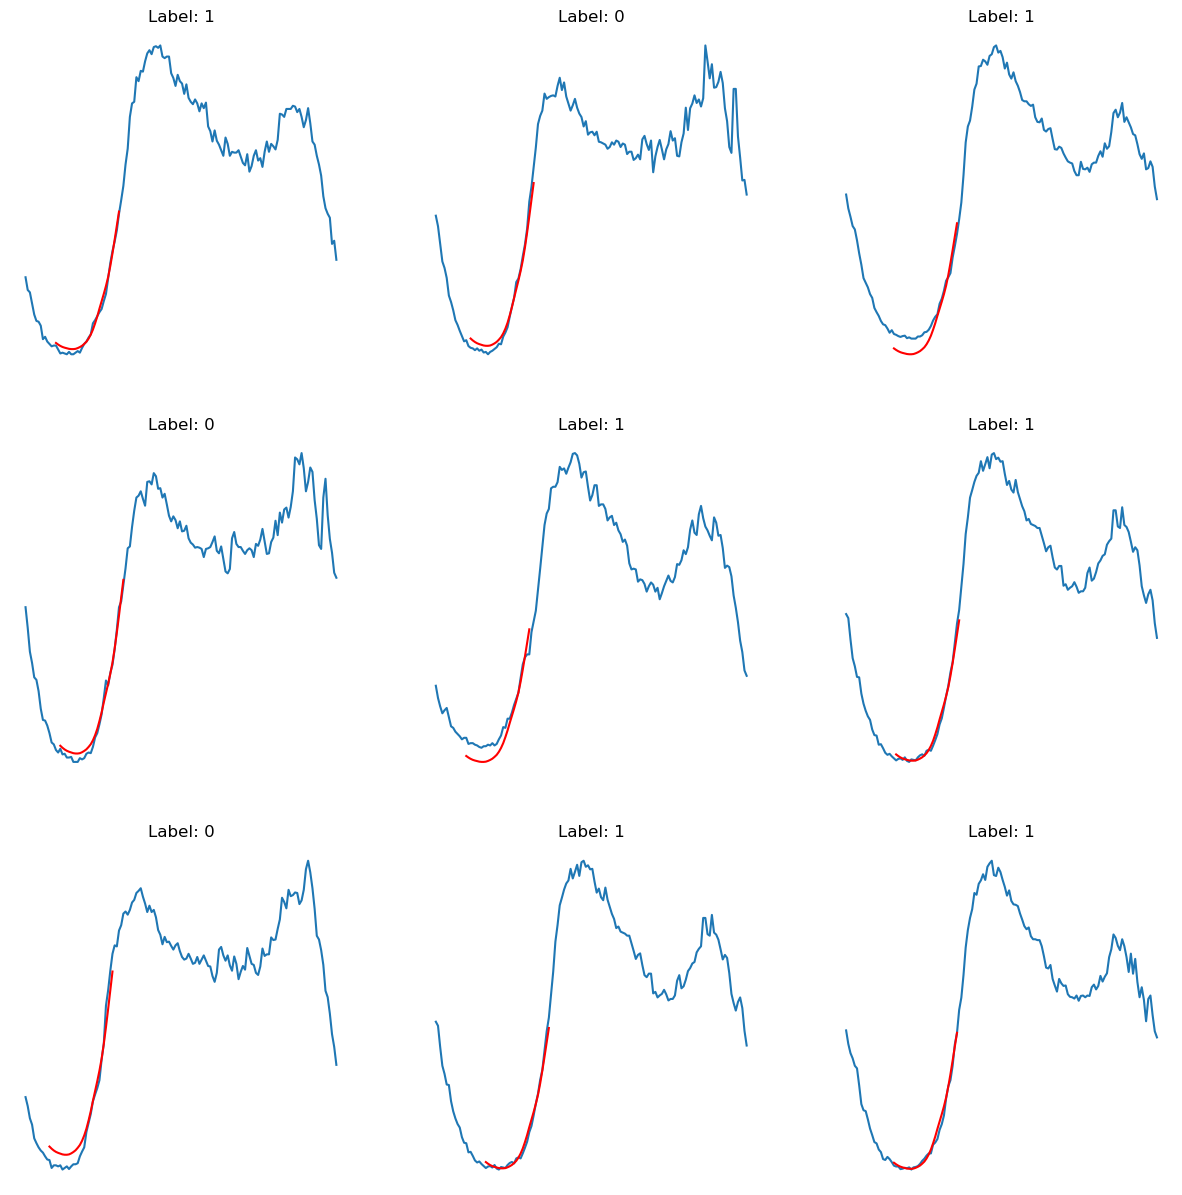

In [70]:
visualize_shapelets(clf, X_train, y_train)

### Arrow Head Dataset

In [71]:
arrow_X, arrow_y = load_arrow_head(return_type="numpy3d")
arrow_X = np.reshape(arrow_X, (arrow_X.shape[0],arrow_X.shape[1]*arrow_X.shape[2]))
arrow_X.shape

(211, 251)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(arrow_X, arrow_y, test_size=0.3)

In [73]:
clf = LearningShapelets(n_shapelets_per_size=0.2)
clf.fit(X_train, y_train)

LearningShapelets()

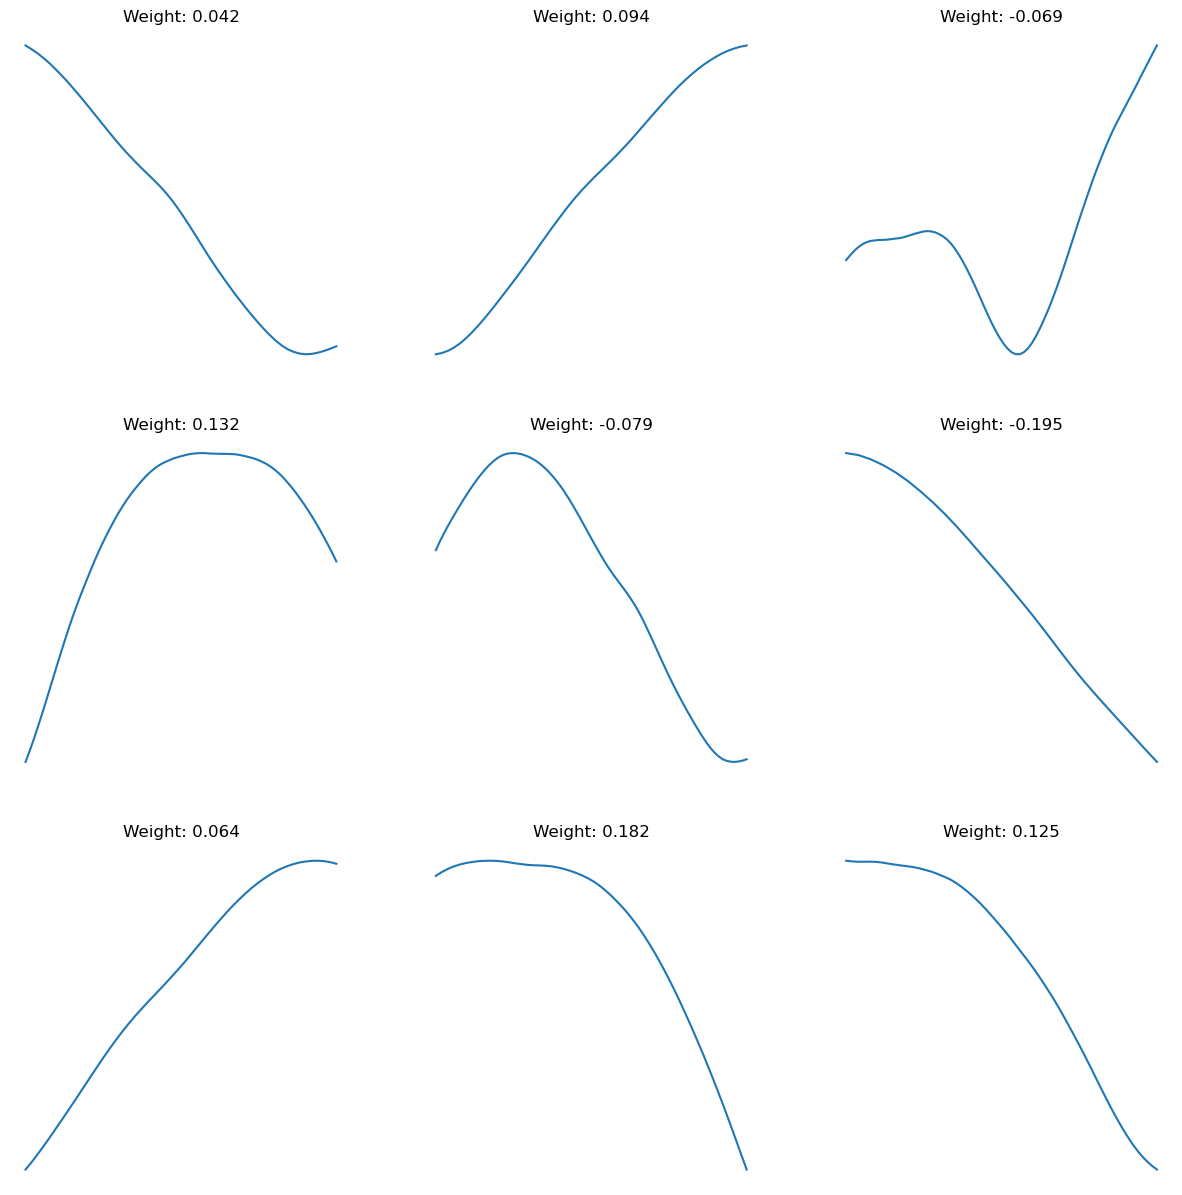

In [74]:
plot_shapelets(clf)

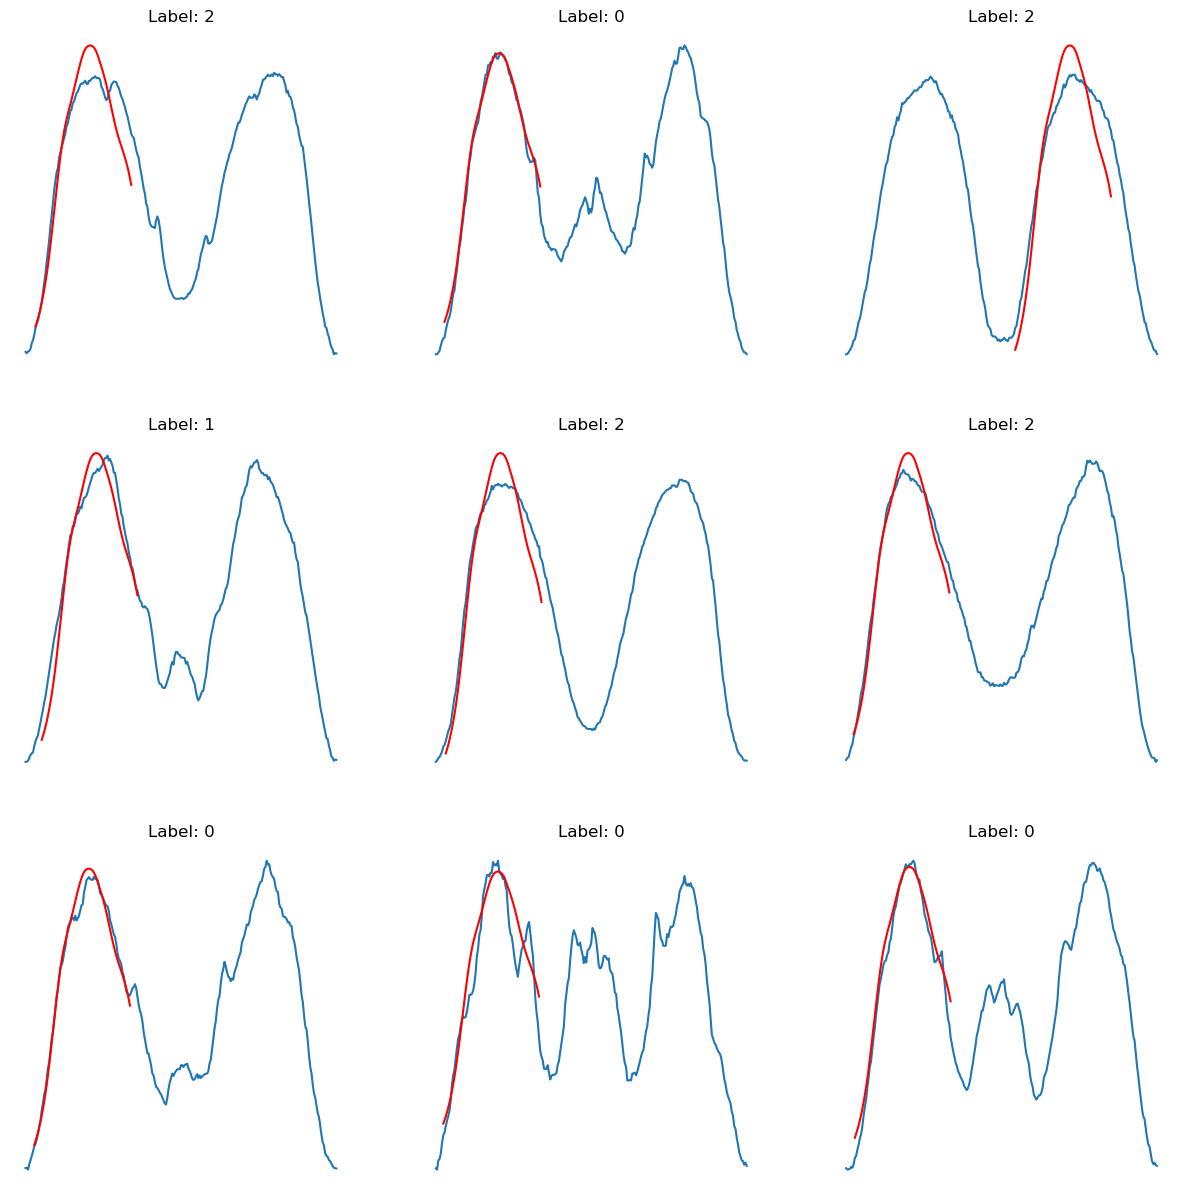

In [75]:
visualize_shapelets(clf, X_train, y_train)

In [76]:
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.640625


### gunpoint dataset

In [84]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [85]:
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X_train, y_train)

LearningShapelets(random_state=42, tol=0.01)

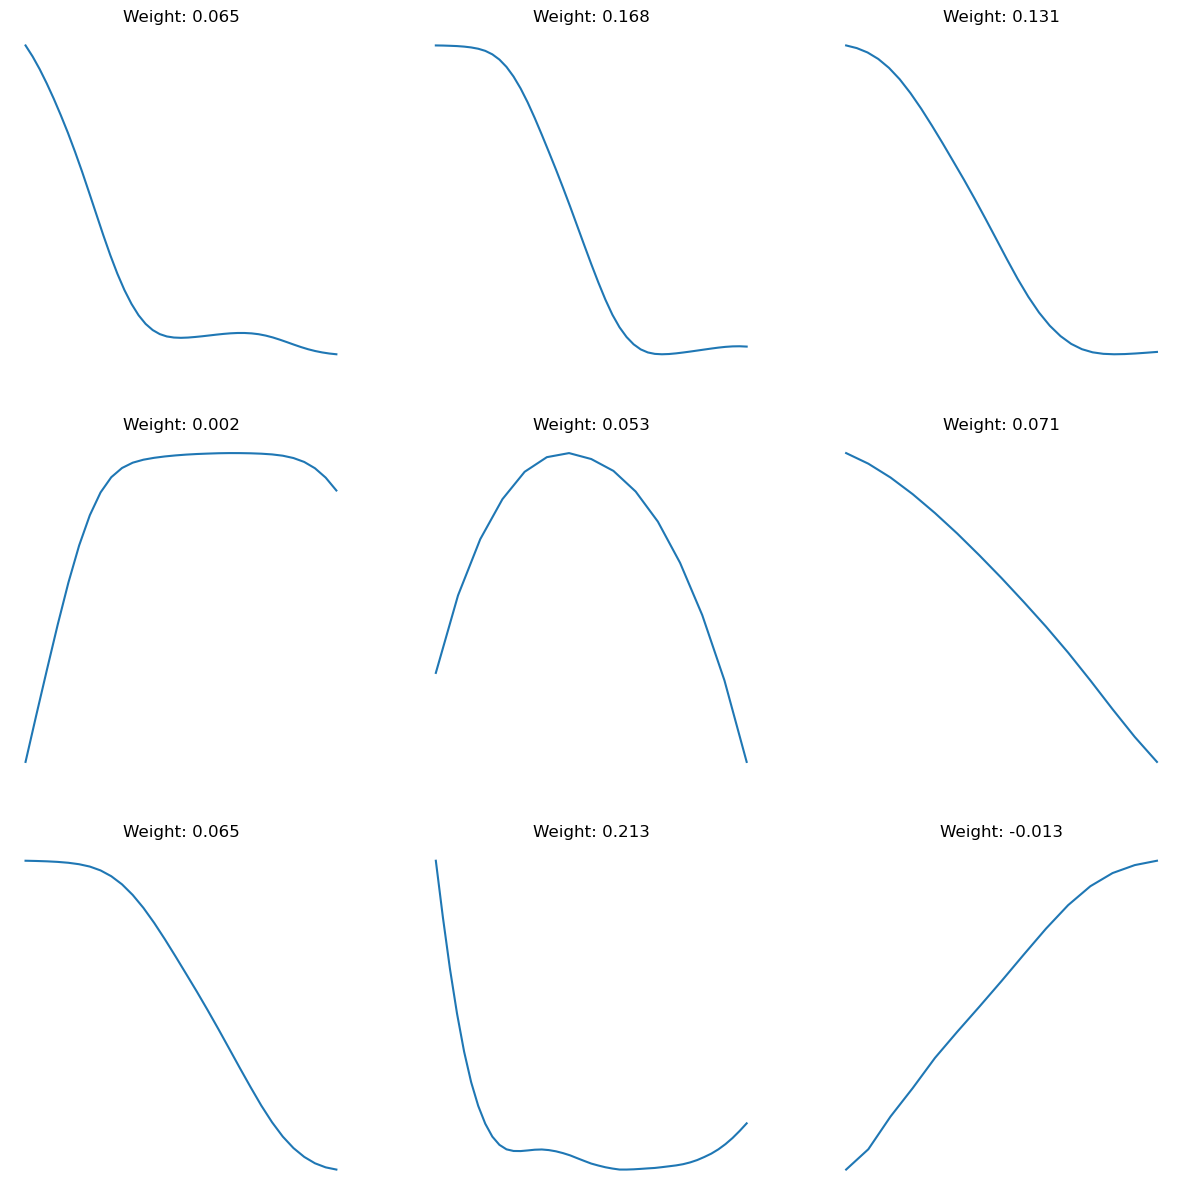

In [86]:
plot_shapelets(clf)

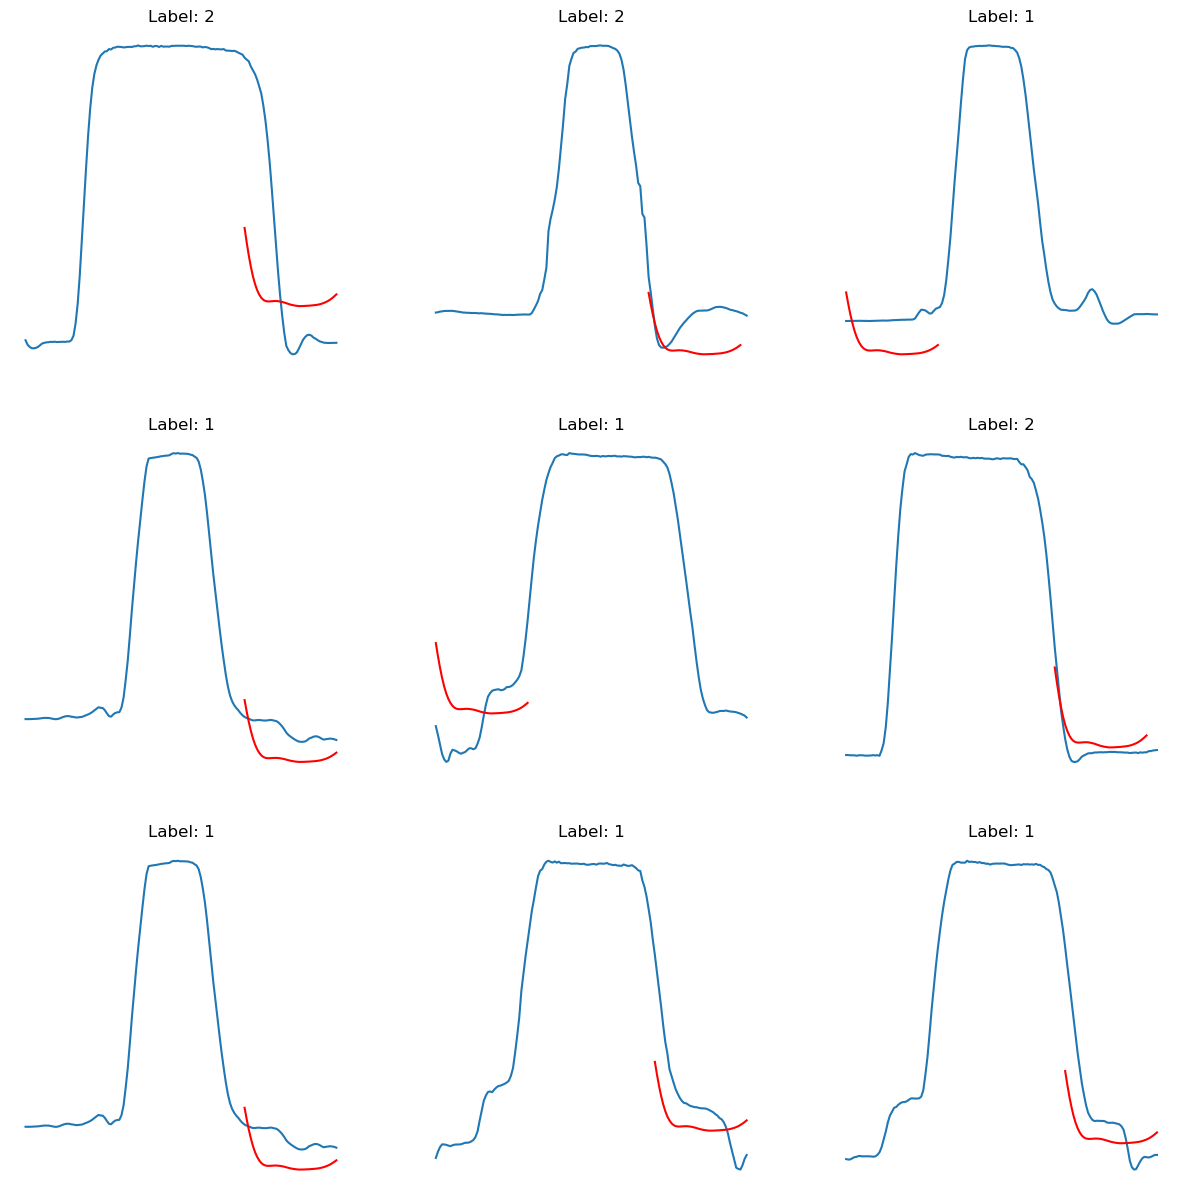

In [87]:
visualize_shapelets(clf, X_train, y_train)


In [88]:
clf.score(X_test, y_test)

0.7666666666666667

## Assignment 3.  - MovieLens

Consider the MovieLens datasets (https://grouplens.org/datasets/movielens/) or the Yelp Open Dataset (https://www.yelp.com/dataset) and try to detect a few the most popular Product Life Cycles by clustering the time series of popularity of the products. You should focus on a selected set of the most frequent products with long enough historical data.

In [4]:
user,item,title = 'userId','movieId','title'

cols = ['User ID','Movie ID','Rating','Timestamp']
ratings_df = pd.read_csv('../a6/ml-100k/u.data', delimiter='\t', 
                         header=None, names=[user,item,'rating','timestamp'])
ratings_df[:3]

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [22]:
movies_df = pd.read_csv('../a6/ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None, 
                     names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])

In [23]:
popularity_df = ratings_df.groupby('movieId').size().reset_index(name='popularity')

In [25]:
filtered_df = popularity_df[popularity_df['popularity'] >= 200]
filtered_df

,movieId,popularity
0,1,452
3,4,209
6,7,392
7,8,219
8,9,299
...,...,...
602,603,209
654,655,227
677,678,219
741,742,267


In [26]:
merged_df = pd.merge(filtered_df, movies_df, on='movieId', how='left')
popularity_time_series = merged_df['popularity'].values.reshape(-1, 1)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(popularity_time_series)

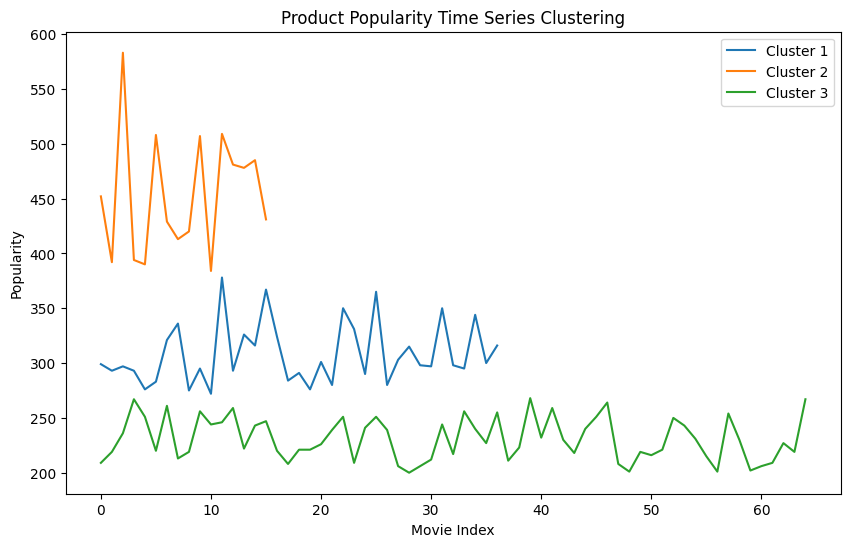

In [27]:
merged_df['cluster_label'] = cluster_labels

plt.figure(figsize=(10, 6))
for label in range(n_clusters):
    cluster_data = merged_df[merged_df['cluster_label'] == label]
    plt.plot(cluster_data['popularity'].values, label=f'Cluster {label+1}')

plt.xlabel('Movie Index')
plt.ylabel('Popularity')
plt.title('Product Popularity Time Series Clustering')
plt.legend()
plt.show()